# Graph and Classification Results: Query Group Distribution & Average Degree

This notebook:
1. Loads graph and classification results from `classifier_filter_results` and `query_group_filter_results`
2. Plots the distribution of `query_group` in each cluster (like `plot_query_group_distribution.py`)
3. Computes the **average degree** for nodes in each query_group within each cluster

In [1]:
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

BASE = Path(".").resolve()  # optional: use to build paths below

/home/jytan12/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Define paths and load bundles

Set `entries` to a list of dicts: each has `results_path` (JSON), `filtered_data_path` (.pkl samples), `graph_path` (.pkl graph, or `None`), and optional `name`.

In [2]:
def load_result_bundle(results_path, filtered_data_path, graph_path=None):
    """Load one bundle from explicit paths. Returns (results, samples, adj_matrix); adj_matrix is None if graph_path is None or missing."""
    results_path = Path(results_path)
    filtered_data_path = Path(filtered_data_path)
    with open(results_path, 'r') as f:
        results = json.load(f)
    with open(filtered_data_path, 'rb') as f:
        samples = pickle.load(f)
    adj_matrix = None
    if graph_path is not None:
        graph_path = Path(graph_path)
        if graph_path.exists():
            with open(graph_path, 'rb') as f:
                adj_matrix = np.asarray(pickle.load(f))
    if adj_matrix is not None and len(samples) != adj_matrix.shape[0]:
        raise ValueError(f"Dimension mismatch: {len(samples)} samples vs graph {adj_matrix.shape[0]} nodes")
    return results, samples, adj_matrix


def load_bundles_from_list(entries):
    """
    Load bundles from a list of dicts. Each dict must have:
      - results_path: path to JSON
      - filtered_data_path: path to .pkl samples
      - graph_path: path to .pkl graph, or None
    Optional: name (display name for this bundle).
    """
    bundles = []
    for i, entry in enumerate(entries):
        name = entry.get('name', f"bundle_{i}")
        try:
            results, samples, adj = load_result_bundle(
                entry['results_path'],
                entry['filtered_data_path'],
                entry.get('graph_path')
            )
            bundles.append({"name": name, "results": results, "samples": samples, "adj_matrix": adj})
        except Exception as e:
            print(f"Skip {name}: {e}")
    return bundles


# --- Set your list of (results, filtered_data, graph) here ---
entries = [
    {
        "results_path": BASE / "classifier_filter_results" / "classifier_filter_results_filling_liquids_15_10_200_google_gemma-2-2b-it.json",
        "filtered_data_path": BASE / "classifier_filter_results" / "filtered_dataset_filling_liquids_15_10_200_google_gemma-2-2b-it.pkl",
        "graph_path": BASE / "classifier_filter_results" / "graph_whole_filling_liquids_15_10_200_google_gemma-2-2b-it.pkl",
        "name": "SAE classifier",
    },
    {
        "results_path": BASE / "query_group_filter_results" / "query_group_filter_results_filling_liquids_15_10_200_google_gemma-2-2b-it_keep_0_1_2_9.json",
        "filtered_data_path": BASE / "classifier_filter_results" / "filtered_dataset_filling_liquids_15_10_200_google_gemma-2-2b-it.pkl",
        "graph_path": BASE / "classifier_filter_results" / "graph_whole_filling_liquids_15_10_200_google_gemma-2-2b-it.pkl",
        "name": "query_group",
    },
]

bundles = load_bundles_from_list(entries)
print(f"Loaded {len(bundles)} bundle(s):")
for b in bundles:
    n = len(b["samples"])
    has_graph = b["adj_matrix"] is not None
    print(f"  - {b['name']}: {n} samples, graph={'yes' if has_graph else 'no'}")

Loaded 2 bundle(s):
  - SAE classifier: 199 samples, graph=yes
  - query_group: 199 samples, graph=yes


## 2. Compute query_group distribution per cluster (like plot_query_group_distribution)

Use `cluster_labels` from the results as cluster id; group samples by cluster and compute counts/proportions per query_group.

In [3]:
def compute_query_group_distributions(results: dict, samples: list):
    """Compute query_group distribution for each cluster. Uses results['cluster_labels'] and K from unique labels."""
    labels = results.get('cluster_labels', results.get('labels', []))
    K = results.get('K', len(set(labels)))
    
    subgraph_samples = defaultdict(list)
    for idx, label in enumerate(labels):
        if idx < len(samples):
            subgraph_samples[label].append(samples[idx])
    
    distributions = {}
    for k in range(K):
        if k in subgraph_samples:
            query_groups = [s['query_group'] for s in subgraph_samples[k]]
            counter = Counter(query_groups)
            total = len(query_groups)
            distributions[k] = {
                'counts': dict(counter),
                'proportions': {qg: count / total for qg, count in counter.items()},
                'total': total
            }
        else:
            distributions[k] = {'counts': {}, 'proportions': {}, 'total': 0}
    return distributions

In [4]:
def plot_distributions_for_bundle(bundle: dict, distributions: dict):
    """Plot query_group distribution per cluster (one figure per bundle)."""
    results = bundle["results"]
    K = len(distributions)
    n_cols = min(3, K)
    n_rows = (K + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if K == 1:
        axes = [axes]
    else:
        axes = np.atleast_1d(axes).flatten()
    
    all_query_groups = set()
    for dist in distributions.values():
        all_query_groups.update(dist['counts'].keys())
    all_query_groups = sorted(all_query_groups)
    
    # Density / IIA for title: iia_kept_cluster (cluster 0), iia_filtered_out_cluster (cluster 1), or dict
    def get_density_iia(k):
        """Return (density, iia) for cluster k. Uses undirected_density_*/iia_* when available, else iia_by_cluster."""
        if 'undirected_density_kept_cluster' in results and 'undirected_density_filtered_out_cluster' in results:
            is_kept = k == results.get('cluster_kept', 0)
            dens = results['undirected_density_kept_cluster'] if is_kept else results['undirected_density_filtered_out_cluster']
            iia = results['iia_kept_cluster'] if is_kept else results['iia_filtered_out_cluster']
            return (dens, iia)
        d = results.get('iia_by_cluster', {})
        if isinstance(d, dict):
            val = d.get(str(k), np.nan)
            return (val, val)  # partition results: single value used for both
        return (np.nan, np.nan)
    
    for k in range(K):
        ax = axes[k]
        dist = distributions[k]
        if dist['total'] == 0:
            ax.text(0.5, 0.5, f'Cluster {k}\n(No samples)', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Cluster {k} (Empty)')
            continue
        counts = [dist['counts'].get(qg, 0) for qg in all_query_groups]
        proportions = [dist['proportions'].get(qg, 0.0) for qg in all_query_groups]
        x_pos = np.arange(len(all_query_groups))
        bars = ax.bar(x_pos, proportions, alpha=0.7, edgecolor='black')
        for i, (bar, count) in enumerate(zip(bars, counts)):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{count}',
                       ha='center', va='bottom', fontsize=9)
        ax.set_xlabel('Query Group')
        ax.set_ylabel('Proportion')
        dens, iia = get_density_iia(k)
        title = f"Cluster {k} (n={dist['total']})"
        if not np.isnan(dens):
            title += f" density: {dens:.2f}"
        if not np.isnan(iia):
            title += f" IIA: {iia:.2f}"
        ax.set_title(title, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(all_query_groups)
        ax.set_ylim(0, max(proportions) * 1.15 if proportions else 1.0)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    for k in range(K, len(axes)):
        axes[k].axis('off')
    task = results.get('task', 'unknown')
    model = results.get('model', 'unknown')
    layer = results.get('layer', 'unknown')
    # Get overall IIA - check common keys
    overall_iia = results.get("iia_whole_graph", np.nan)
    overall_density = results.get("undirected_density_whole_graph", np.nan)
    title = f"Query Group Distribution by Cluster — {bundle['name']}\n{task} | {model} | Layer {layer}"
    if not np.isnan(overall_iia):
        title += f" | Overall IIA: {overall_iia:.2f}, Overall Density: {overall_density:.2f}"
    fig.suptitle(title, fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

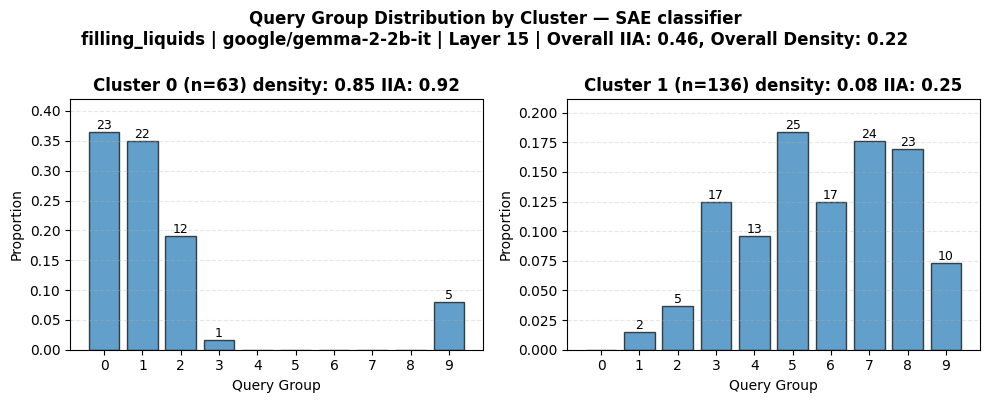

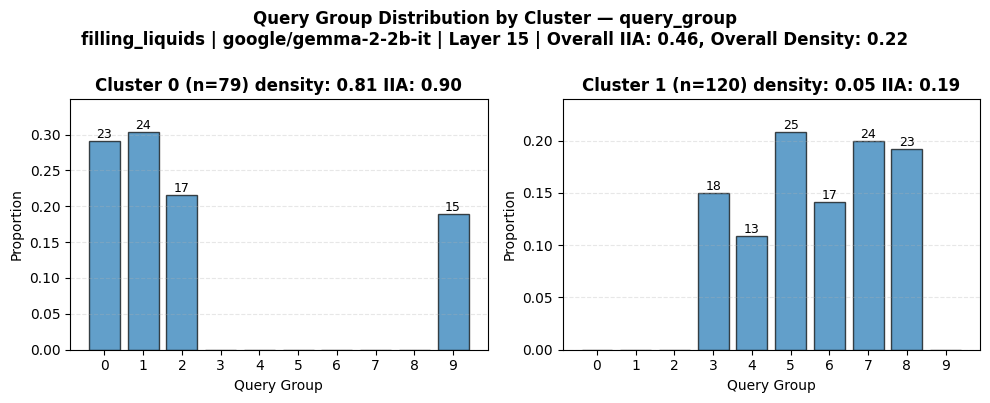

In [5]:
# Compute distributions and plot for each bundle
for bundle in bundles:
    dists = compute_query_group_distributions(bundle["results"], bundle["samples"])
    fig = plot_distributions_for_bundle(bundle, dists)
    plt.show()

## 3. Average degree per query_group per cluster

For each cluster and each query_group, compute the average (undirected) degree of nodes that belong to that cluster and have that query_group. Degree is computed from the adjacency matrix (symmetrized if directed).

In [6]:
def node_degrees(adj_matrix: np.ndarray):
    """Undirected degree per node: count only bi-directed edges (i->j and j->i both exist)."""
    adj = np.asarray(adj_matrix)
    # Undirected edge (i,j) exists only if both (i,j) and (j,i) exist in directed graph
    adj_undirected = adj & adj.T
    return adj_undirected.sum(axis=1)


def average_degree_by_cluster_and_query_group(results: dict, samples: list, adj_matrix: np.ndarray):
    """
    Average degree **within each cluster** (bi-directed edges only).
    Returns: dict[cluster_id -> dict[query_group -> {'mean_degree', 'std_degree', 'count'}]]
    """
    labels = np.asarray(results.get('cluster_labels', results.get('labels', [])))
    adj = np.asarray(adj_matrix)
    adj_undirected = adj & adj.T
    n = len(labels)
    within_cluster_degrees = np.zeros(n)
    for k in np.unique(labels):
        mask_k = (labels == k)
        # Degree of each node in cluster k = number of neighbors in same cluster (bi-directed)
        within_cluster_degrees[mask_k] = adj_undirected[mask_k][:, mask_k].sum(axis=1)
    
    # (cluster_id, query_group) -> list of within-cluster degrees
    by_cluster_qg = defaultdict(lambda: defaultdict(list))
    for idx in range(min(len(labels), len(samples), n)):
        k = labels[idx]
        qg = samples[idx]['query_group']
        by_cluster_qg[k][qg].append(within_cluster_degrees[idx])
    
    out = defaultdict(dict)
    for k in sorted(by_cluster_qg.keys()):
        for qg in sorted(by_cluster_qg[k].keys()):
            degs = by_cluster_qg[k][qg]
            out[k][qg] = {
                'mean_degree': float(np.mean(degs)),
                'std_degree': float(np.std(degs)) if len(degs) > 1 else 0.0,
                'count': len(degs)
            }
    return dict(out)


def print_avg_degree_table(avg_degree_stats: dict, bundle_name: str):
    print(f"\n{'='*60}")
    print(f"Average within-cluster degree by cluster and query_group — {bundle_name}")
    print(f"{'='*60}")
    for k in sorted(avg_degree_stats.keys()):
        print(f"\nCluster {k}:")
        for qg in sorted(avg_degree_stats[k].keys()):
            s = avg_degree_stats[k][qg]
            print(f"  Query group {qg}: mean_degree = {s['mean_degree']:.2f} (std = {s['std_degree']:.2f}, n = {s['count']})")
    print()


def degree_lists_by_cluster_and_query_group(results: dict, samples: list, adj_matrix: np.ndarray):
    """
    Return raw within-cluster degree lists: dict[cluster_id -> dict[query_group -> list of degrees]].
    """
    labels = np.asarray(results.get('cluster_labels', results.get('labels', [])))
    adj = np.asarray(adj_matrix)
    adj_undirected = adj & adj.T
    n = len(labels)
    within_cluster_degrees = np.zeros(n)
    for k in np.unique(labels):
        mask_k = (labels == k)
        within_cluster_degrees[mask_k] = adj_undirected[mask_k][:, mask_k].sum(axis=1)
    by_cluster_qg = defaultdict(lambda: defaultdict(list))
    for idx in range(min(len(labels), len(samples), n)):
        k = labels[idx]
        qg = samples[idx]['query_group']
        by_cluster_qg[k][qg].append(float(within_cluster_degrees[idx]))
    return {k: dict(v) for k, v in by_cluster_qg.items()}

In [7]:
# Compute and display average degree for each bundle that has a graph
for bundle in bundles:
    if bundle["adj_matrix"] is None:
        print(f"Skipping {bundle['name']} (no graph).")
        continue
    avg_degree_stats = average_degree_by_cluster_and_query_group(
        bundle["results"], bundle["samples"], bundle["adj_matrix"]
    )
    print_avg_degree_table(avg_degree_stats, bundle["name"])
    # Optionally store for later use
    bundle["avg_degree_by_cluster_qg"] = avg_degree_stats


Average within-cluster degree by cluster and query_group — SAE classifier

Cluster 0:
  Query group 0: mean_degree = 56.83 (std = 2.48, n = 23)
  Query group 1: mean_degree = 56.68 (std = 1.92, n = 22)
  Query group 2: mean_degree = 46.42 (std = 10.48, n = 12)
  Query group 3: mean_degree = 8.00 (std = 0.00, n = 1)
  Query group 9: mean_degree = 41.40 (std = 10.91, n = 5)

Cluster 1:
  Query group 1: mean_degree = 32.00 (std = 2.00, n = 2)
  Query group 2: mean_degree = 28.00 (std = 5.76, n = 5)
  Query group 3: mean_degree = 10.24 (std = 3.80, n = 17)
  Query group 4: mean_degree = 7.15 (std = 2.88, n = 13)
  Query group 5: mean_degree = 7.76 (std = 2.93, n = 25)
  Query group 6: mean_degree = 6.76 (std = 2.56, n = 17)
  Query group 7: mean_degree = 9.00 (std = 3.95, n = 24)
  Query group 8: mean_degree = 9.91 (std = 3.59, n = 23)
  Query group 9: mean_degree = 25.00 (std = 7.43, n = 10)


Average within-cluster degree by cluster and query_group — query_group

Cluster 0:
  Query grou

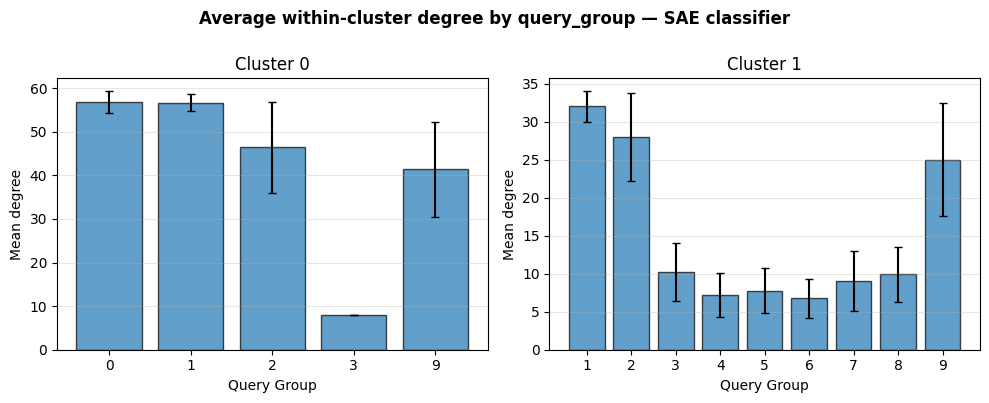

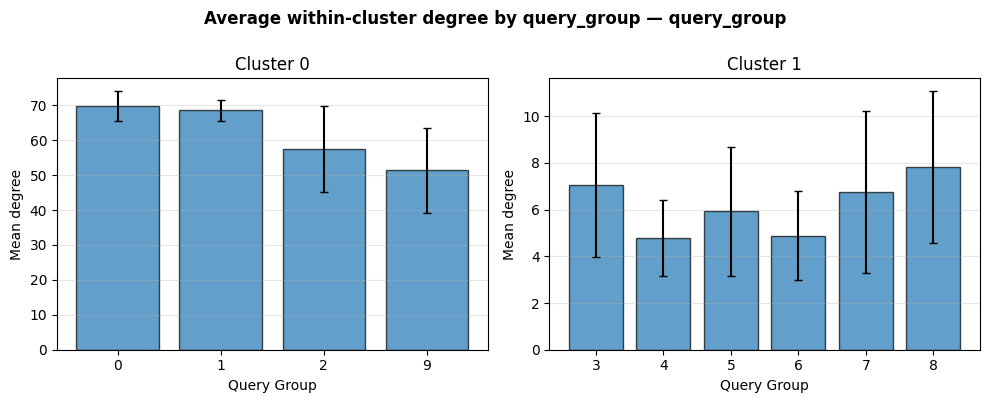

In [8]:
# Optional: plot average degree per query_group for each cluster (bar chart)
def plot_avg_degree_by_cluster_qg(avg_degree_stats: dict, bundle_name: str):
    K = len(avg_degree_stats)
    if K == 0:
        return None
    n_cols = min(3, K)
    n_rows = (K + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).flatten()
    for ki, k in enumerate(sorted(avg_degree_stats.keys())):
        ax = axes[ki]
        qg_list = sorted(avg_degree_stats[k].keys())
        means = [avg_degree_stats[k][qg]['mean_degree'] for qg in qg_list]
        stds = [avg_degree_stats[k][qg]['std_degree'] for qg in qg_list]
        x = np.arange(len(qg_list))
        ax.bar(x, means, yerr=stds, alpha=0.7, edgecolor='black', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(qg_list)
        ax.set_xlabel('Query Group')
        ax.set_ylabel('Mean degree')
        ax.set_title(f'Cluster {k}')
        ax.grid(axis='y', alpha=0.3)
    for ki in range(K, len(axes)):
        axes[ki].axis('off')
    fig.suptitle(f'Average within-cluster degree by query_group — {bundle_name}', fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

for bundle in bundles:
    if bundle.get("avg_degree_by_cluster_qg") is None:
        continue
    fig = plot_avg_degree_by_cluster_qg(bundle["avg_degree_by_cluster_qg"], bundle["name"])
    if fig is not None:
        plt.show()

In [9]:
## 4. Degree distribution for query group 9 in each cluster

# For each cluster, plot the distribution (histogram) of within-cluster degrees for nodes that belong to **query group 9**.
print(f"Degree distribution for query group 9 in {bundle['name']}:")

Degree distribution for query group 9 in query_group:


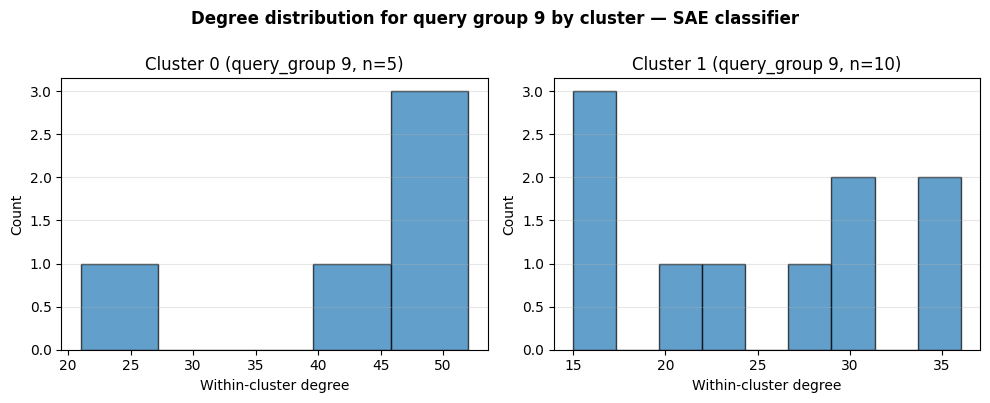

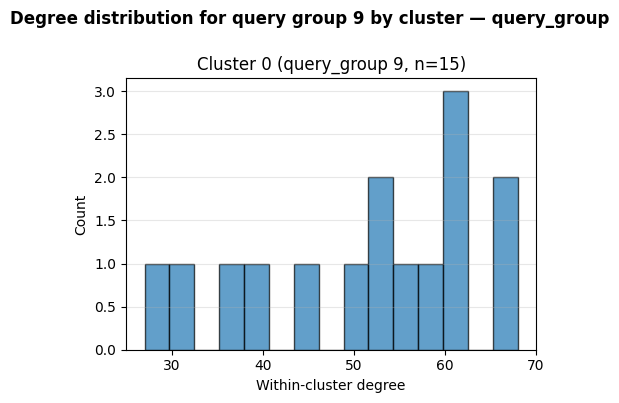

In [10]:
QUERY_GROUP_9 = 9

def plot_degree_distribution_qg9_per_cluster(degree_lists: dict, bundle_name: str, qg: int = QUERY_GROUP_9):
    """Plot degree distribution for a specific query_group (default 9) in each cluster."""
    clusters_with_qg = [k for k in sorted(degree_lists.keys()) if qg in degree_lists[k]]
    if not clusters_with_qg:
        print(f"No cluster has query_group {qg} for {bundle_name}. Skipping.")
        return None
    K = len(clusters_with_qg)
    n_cols = min(3, K)
    n_rows = (K + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).flatten()
    for ki, k in enumerate(clusters_with_qg):
        ax = axes[ki]
        degs = degree_lists[k][qg]
        ax.hist(degs, bins=min(max(len(set(degs)), 5), 25), edgecolor='black', alpha=0.7)
        ax.set_xlabel('Within-cluster degree')
        ax.set_ylabel('Count')
        ax.set_title(f'Cluster {k} (query_group {qg}, n={len(degs)})')
        ax.grid(axis='y', alpha=0.3)
    for ki in range(K, len(axes)):
        axes[ki].axis('off')
    fig.suptitle(f'Degree distribution for query group {qg} by cluster — {bundle_name}', fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

for bundle in bundles:
    if bundle["adj_matrix"] is None:
        print(f"Skipping {bundle['name']} (no graph).")
        continue
    degree_lists = degree_lists_by_cluster_and_query_group(
        bundle["results"], bundle["samples"], bundle["adj_matrix"]
    )
    fig = plot_degree_distribution_qg9_per_cluster(degree_lists, bundle["name"])
    if fig is not None:
        plt.show()

## Visualize the Graph

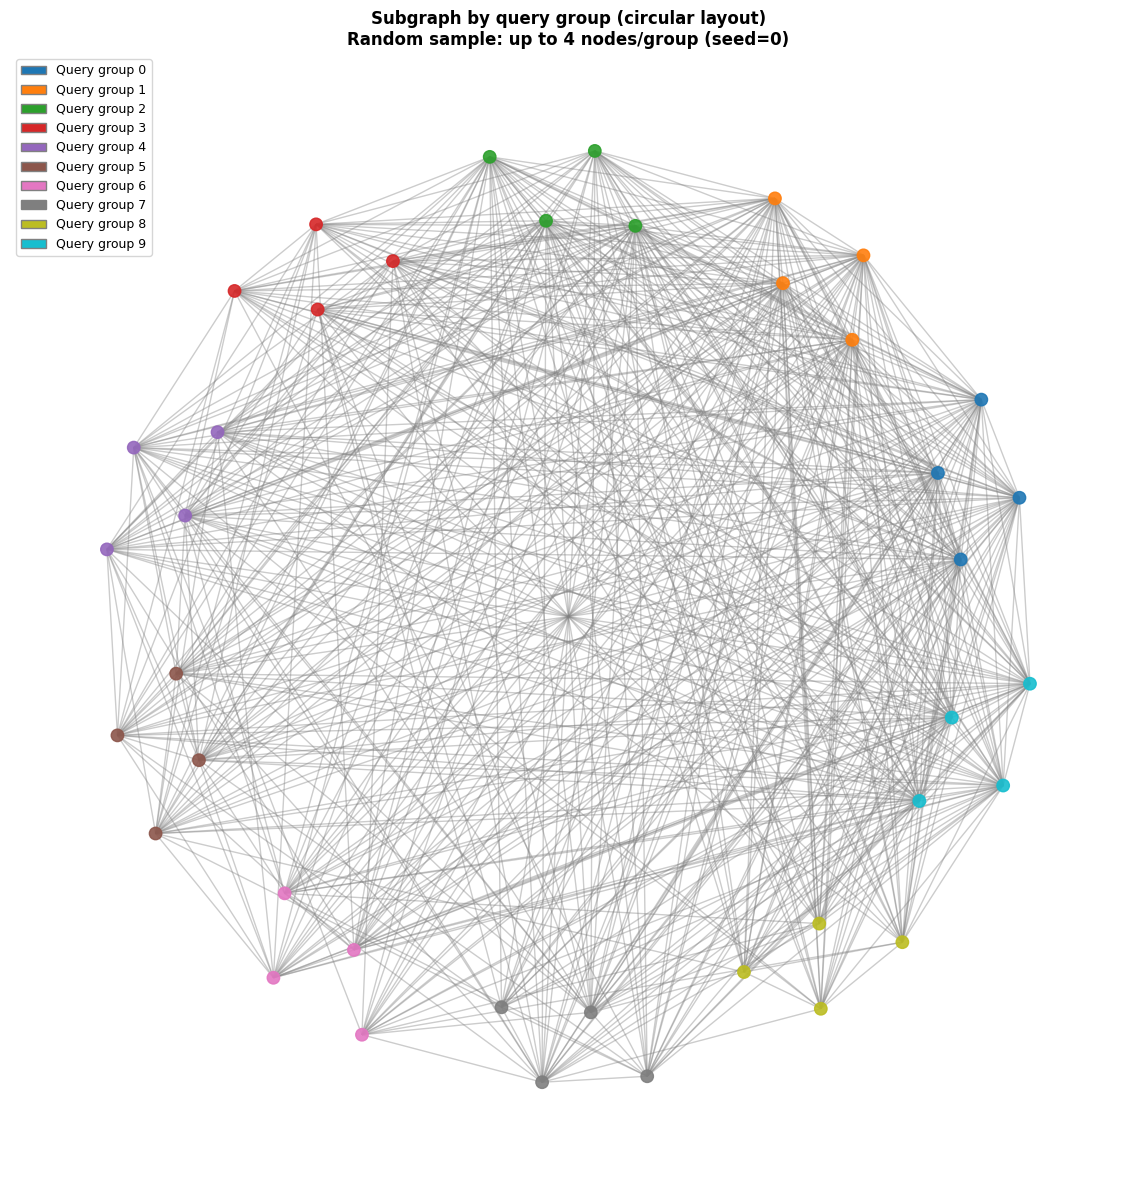

In [11]:
import networkx as nx

def circular_layout_by_query_group(samples, radius=1.0, inner_radius_frac=0.7):
    """
    Place nodes so that same query_group are in the same sector of a circle.
    Returns pos: dict node_id -> (x, y), and list of query_group per node index.
    """
    n = len(samples)
    query_groups = [s.get("query_group", 0) for s in samples]
    unique_qg = sorted(set(query_groups))
    num_groups = len(unique_qg)
    qg_to_idx = {q: i for i, q in enumerate(unique_qg)}
    # nodes per group: group_id -> list of node indices
    nodes_by_group = defaultdict(list)
    for i in range(n):
        qg = query_groups[i]
        if qg in qg_to_idx:
            nodes_by_group[qg_to_idx[qg]].append(i)

    pos = {}
    for g_idx, qg in enumerate(unique_qg):
        node_list = nodes_by_group.get(g_idx, [])
        if not node_list:
            continue
        # sector: angles from 2*pi*g_idx/num_groups to 2*pi*(g_idx+1)/num_groups
        angle_start = 2 * np.pi * g_idx / num_groups
        angle_end = 2 * np.pi * (g_idx + 1) / num_groups
        angle_span = angle_end - angle_start
        # place nodes in this sector on a small arc (avoid overlap)
        m = len(node_list)
        for j, node_id in enumerate(node_list):
            # angle: spread within sector, leave small margin
            margin = 0.05 * angle_span
            t = (j + 1) / (m + 1)  # 0..1
            angle = angle_start + margin + t * (angle_span - 2 * margin)
            # radius: slight spread between inner and outer for visibility
            r = inner_radius_frac * radius + (1 - inner_radius_frac) * radius * (0.5 + 0.5 * (j % 2))
            pos[node_id] = (r * np.cos(angle), r * np.sin(angle))
    return pos, query_groups, unique_qg


def _sample_node_ids_by_query_group(samples, max_per_group=50, seed=0):
    """Return a sorted list of node indices, sampling up to max_per_group per query_group."""
    rng = np.random.default_rng(seed)
    nodes_by_qg = defaultdict(list)
    for i, s in enumerate(samples):
        nodes_by_qg[s.get("query_group", 0)].append(i)
    sampled = []
    for qg in sorted(nodes_by_qg.keys()):
        ids = np.asarray(nodes_by_qg[qg], dtype=int)
        if len(ids) <= max_per_group:
            sampled.extend(ids.tolist())
        else:
            sampled.extend(rng.choice(ids, size=max_per_group, replace=False).tolist())
    return sorted(sampled)


def _circular_layout_for_node_ids(samples, node_ids, radius=1.0, inner_radius_frac=0.7):
    """Circular layout by query_group for a subset of node indices."""
    node_ids = list(node_ids)
    query_groups = [samples[i].get("query_group", 0) for i in node_ids]
    unique_qg = sorted(set(query_groups))
    num_groups = len(unique_qg)
    qg_to_idx = {q: i for i, q in enumerate(unique_qg)}

    nodes_by_group = defaultdict(list)
    for node_id, qg in zip(node_ids, query_groups):
        nodes_by_group[qg_to_idx[qg]].append(node_id)

    pos = {}
    for g_idx, qg in enumerate(unique_qg):
        node_list = nodes_by_group.get(g_idx, [])
        if not node_list:
            continue
        angle_start = 2 * np.pi * g_idx / num_groups
        angle_end = 2 * np.pi * (g_idx + 1) / num_groups
        angle_span = angle_end - angle_start
        m = len(node_list)
        for j, node_id in enumerate(node_list):
            margin = 0.05 * angle_span
            t = (j + 1) / (m + 1)
            angle = angle_start + margin + t * (angle_span - 2 * margin)
            r = inner_radius_frac * radius + (1 - inner_radius_frac) * radius * (0.5 + 0.5 * (j % 2))
            pos[node_id] = (r * np.cos(angle), r * np.sin(angle))
    return pos, query_groups, unique_qg


def plot_whole_graph_by_query_group(
    bundle,
    figsize=(12, 12),
    node_size=80,
    edge_alpha=0.4,
    max_nodes_per_query_group=4,
    seed=0,
):
    """Plot a subgraph by sampling up to N nodes per query_group."""
    adj_matrix = np.asarray(bundle["adj_matrix"])
    samples = bundle["samples"]
    n = adj_matrix.shape[0]
    if len(samples) != n:
        raise ValueError("Samples length does not match graph size")
    # ensure undirected
    adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

    sampled_node_ids = _sample_node_ids_by_query_group(
        samples,
        max_per_group=max_nodes_per_query_group,
        seed=seed,
    )
    if len(sampled_node_ids) == 0:
        raise ValueError("No nodes sampled; check samples/query_group fields")

    G_full = nx.from_numpy_array(adj_matrix)
    G = G_full.subgraph(sampled_node_ids).copy()
    pos, query_groups, unique_qg = _circular_layout_for_node_ids(samples, sampled_node_ids)

    # colormap: one color per query group (present in sampled nodes)
    num_groups = len(unique_qg)
    cmap = plt.cm.tab10 if num_groups <= 10 else plt.cm.tab20
    qg_to_color = {qg: cmap(i % cmap.N) for i, qg in enumerate(unique_qg)}
    node_colors = [qg_to_color.get(samples[nid].get("query_group", 0), (0.5, 0.5, 0.5, 1.0)) for nid in G.nodes()]

    fig, ax = plt.subplots(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha, width=1, ax=ax, edge_color="gray")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, ax=ax, alpha=0.9)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=qg_to_color[qg], edgecolor="gray", label=f"Query group {qg}")
        for qg in unique_qg
    ]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=9)
    ax.set_title(
        f"Subgraph by query group (circular layout)\nRandom sample: up to {max_nodes_per_query_group} nodes/group (seed={seed})",
        fontsize=12,
        fontweight="bold",
    )
    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()
    return fig, ax

# Pick a bundle that has the graph (e.g. query_group or first one)
bundle_with_graph = next((b for b in bundles if b["adj_matrix"] is not None), None)
if bundle_with_graph is not None:
    fig, _ = plot_whole_graph_by_query_group(bundle_with_graph)
    plt.show()
else:
    print("No bundle with graph found. Load bundles with graph_path set.")

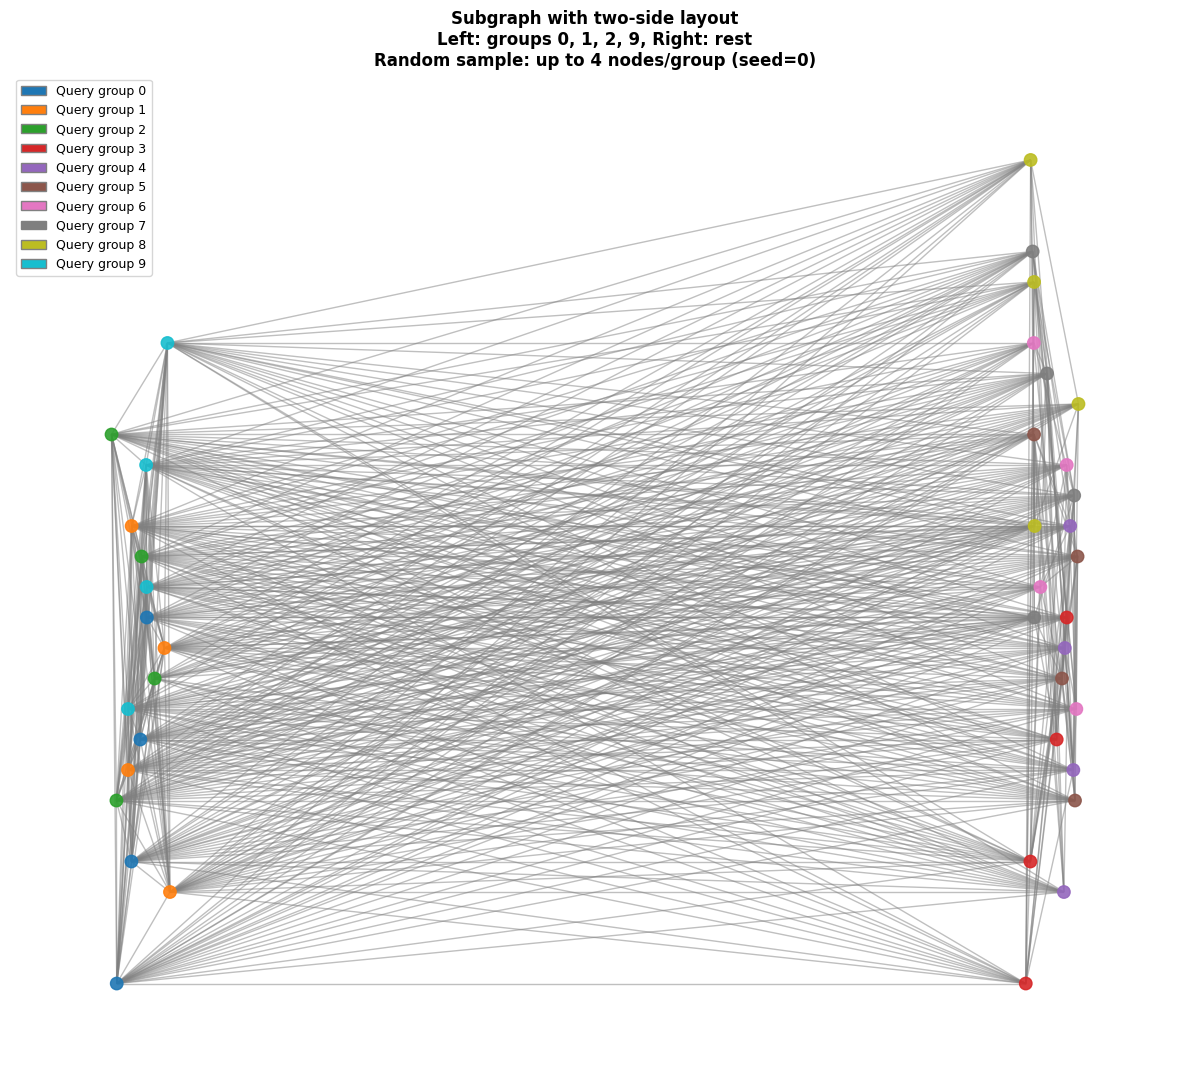

In [16]:
# Fixed version: Use Cartesian coordinates for true two-side layout
def _two_side_layout_for_node_ids_fixed(samples, node_ids, left_groups=[0, 1, 2, 9], x_separation=3.0, y_spread=2.0):
    """Layout that groups nodes into two sides: left_groups on left, rest on right.
    Uses Cartesian coordinates instead of circular layout."""
    node_ids = list(node_ids)
    query_groups = [samples[i].get("query_group", 0) for i in node_ids]
    unique_qg = sorted(set(query_groups))
    left_groups_set = set(left_groups)
    
    # Separate groups into left and right
    left_qg = [qg for qg in unique_qg if qg in left_groups_set]
    right_qg = [qg for qg in unique_qg if qg not in left_groups_set]
    
    nodes_by_group = defaultdict(list)
    for node_id, qg in zip(node_ids, query_groups):
        nodes_by_group[qg].append(node_id)
    
    pos = {}
    
    # Left side: groups 0, 1, 2, 9
    # x coordinate is negative (left side)
    left_x = -x_separation / 2
    
    if left_qg:
        for g_idx, qg in enumerate(left_qg):
            node_list = nodes_by_group.get(qg, [])
            if not node_list:
                continue
            
            m = len(node_list)
            # Distribute nodes vertically for this group
            for j, node_id in enumerate(node_list):
                # y coordinate: distribute evenly from -y_spread/2 to y_spread/2
                # Add some vertical spacing between groups
                group_offset = g_idx * 0.3  # Small offset per group
                t = (j + 1) / (m + 1)  # 0 to 1
                y = -y_spread/2 + t * y_spread + group_offset
                # Add small random jitter for visibility
                np.random.seed(42 + node_id)  # Deterministic jitter
                x_jitter = (np.random.random() - 0.5) * 0.2
                pos[node_id] = (left_x + x_jitter, y)
    
    # Right side: rest of the groups
    # x coordinate is positive (right side)
    right_x = x_separation / 2
    
    if right_qg:
        for g_idx, qg in enumerate(right_qg):
            node_list = nodes_by_group.get(qg, [])
            if not node_list:
                continue
            
            m = len(node_list)
            # Distribute nodes vertically for this group
            for j, node_id in enumerate(node_list):
                # y coordinate: distribute evenly from -y_spread/2 to y_spread/2
                # Add some vertical spacing between groups
                group_offset = g_idx * 0.3  # Small offset per group
                t = (j + 1) / (m + 1)  # 0 to 1
                y = -y_spread/2 + t * y_spread + group_offset
                # Add small random jitter for visibility
                np.random.seed(42 + node_id)  # Deterministic jitter
                x_jitter = (np.random.random() - 0.5) * 0.2
                pos[node_id] = (right_x + x_jitter, y)
    
    return pos, query_groups, unique_qg


def plot_whole_graph_two_sides_fixed(
    bundle,
    figsize=(12, 12),
    node_size=80,
    edge_alpha=0.5,
    max_nodes_per_query_group=4,
    seed=0,
    left_groups=[0, 1, 2, 9],
):
    """Plot a subgraph with groups 0,1,2,9 on left side and rest on right side.
    Uses the same random sample as plot_whole_graph_by_query_group with same seed."""
    adj_matrix = np.asarray(bundle["adj_matrix"])
    samples = bundle["samples"]
    n = adj_matrix.shape[0]
    if len(samples) != n:
        raise ValueError("Samples length does not match graph size")
    # ensure undirected
    adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

    # Use the same sampling function with the same seed
    sampled_node_ids = _sample_node_ids_by_query_group(
        samples,
        max_per_group=max_nodes_per_query_group,
        seed=seed,
    )
    if len(sampled_node_ids) == 0:
        raise ValueError("No nodes sampled; check samples/query_group fields")

    G_full = nx.from_numpy_array(adj_matrix)
    G = G_full.subgraph(sampled_node_ids).copy()
    pos, query_groups, unique_qg = _two_side_layout_for_node_ids_fixed(samples, sampled_node_ids, left_groups=left_groups)

    # colormap: one color per query group (present in sampled nodes)
    num_groups = len(unique_qg)
    cmap = plt.cm.tab10 if num_groups <= 10 else plt.cm.tab20
    qg_to_color = {qg: cmap(i % cmap.N) for i, qg in enumerate(unique_qg)}
    node_colors = [qg_to_color.get(samples[nid].get("query_group", 0), (0.5, 0.5, 0.5, 1.0)) for nid in G.nodes()]

    fig, ax = plt.subplots(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha, width=1, ax=ax, edge_color="gray")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, ax=ax, alpha=0.9)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=qg_to_color[qg], edgecolor="gray", label=f"Query group {qg}")
        for qg in unique_qg
    ]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=9)
    
    left_groups_str = ", ".join(map(str, left_groups))
    ax.set_title(
        f"Subgraph with two-side layout\nLeft: groups {left_groups_str}, Right: rest\nRandom sample: up to {max_nodes_per_query_group} nodes/group (seed={seed})",
        fontsize=12,
        fontweight="bold",
    )
    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()
    return fig, ax


# Plot the same random sample but with two-side layout (fixed version)
if bundle_with_graph is not None:
    fig, _ = plot_whole_graph_two_sides_fixed(bundle_with_graph, seed=0, max_nodes_per_query_group=4)
    plt.show()
else:
    print("No bundle with graph found. Load bundles with graph_path set.")